# Getting started

Install the requirements:

In [ ]:
!python3 -m pip install kaggle_environments

     |████████████████████████████████| 112kB 12.5MB/s 
     |████████████████████████████████| 61kB 4.4MB/s 
ERROR: nbclient 0.5.3 has requirement jupyter-client>=6.1.5, but you'll have jupyter-client 5.3.5 which is incompatible.
  Found existing installation: jsonschema 2.6.0
    Uninstalling jsonschema-2.6.0:
      Successfully uninstalled jsonschema-2.6.0


In [ ]:
# this should now run
import kaggle_environments

Loading environment football failed: No module named 'gfootball'


In [ ]:
from kaggle_environments.envs.hungry_geese.hungry_geese import Observation, Configuration, Action, row_col, GreedyAgent
from kaggle_environments import evaluate, make, utils

If any problems were encountered, [this](https://www.kaggle.com/antimatter543/running-games-locally-with-jupyter-notebook) post has some info on running Kaggle locally

Useful information:

```python
# Setup a hungry_geese environment and run agent vs a random.
# Set debug to False if you don't want the printed statements (or just remove the prints in the agent)
env = make("hungry_geese", debug=True) 

# each element in the list is a different opponent
env.run([agent, agent,agent, agent])

# visualize the environment
env.render(mode="ipython", width=500, height=450)
```

Creates a simple random agent

In [ ]:
import numpy as np
actions = np.array(["EAST", "SOUTH", "NORTH", "WEST"])

def random_agent(obs, config):
    return np.random.choice(actions)

random_agent({}, {})

'WEST'

As we can see above, a random agent is quite bad, since it sometimes goes back onto itself, therefore losing; we can do slightly better:

In [ ]:
from kaggle_environments.envs.hungry_geese.hungry_geese import Observation, Configuration, Action, row_col
from kaggle_environments import evaluate, make, utils
opp_actions = {'EAST': 'WEST', 'WEST': 'EAST', 'NORTH':'SOUTH', 'SOUTH':'NORTH'}

# Creates a class for an agent so we can keep track of the last action
class RandomAgent:
    def __init__(self, configuration: Configuration):
        self.configuration = configuration
        self.last_action = None

    def __call__(self, observation: Observation):
        action = np.random.choice(actions) 
        while action == opp_actions.get(self.last_action, ""):
            action = np.random.choice(actions)
        self.last_action = action
        return action

cached_agents = {}
def agent(obs, config):
    index = obs["index"]
    if index not in cached_agents :
        cached_agents[index] = RandomAgent(Configuration(config))
    return cached_agents[index](Observation(obs))

This gives us much better results (at least we don't go backwards):

Let's try making a stupid neural network.

In [ ]:
!python -m pip install ribs


     |████████████████████████████████| 51kB 3.5MB/s 


In [ ]:
import torch
from torch import nn
from torch.nn.functional import relu
from pdb import set_trace as T

HEIGHT = 7
WIDTH = 11
# One hot encoding: empty, food, goose 1, 2, 3, 4 
N_CHAN = 6

def bin_from_list(pos_list):
  ''' Get a binary array with 1's in positions given in pos_list, which are 
  positions in a 1D, left-to-right, top-to-bottom unraveling of the board.'''
  idxs = np.array(pos_list)
  idxs = idxs // WIDTH, idxs % WIDTH
  bin_arr = np.zeros(shape=(HEIGHT, WIDTH), dtype=np.uint8)
  bin_arr[idxs[0], idxs[1]] = 1
  bin_arr = bin_arr.reshape((1, *bin_arr.shape))
  return torch.Tensor(bin_arr)

def obs_to_onehot(obs, config):
  assert WIDTH == config['columns']
  assert HEIGHT == config['rows']
  obs_arr = torch.zeros(size=(N_CHAN, HEIGHT, WIDTH), dtype=torch.uint8)
  # Place food on observation array
  obs_arr[1] = bin_from_list(obs['food'])
  # Now observe ourselves
  geese_idxs = obs['geese']
  self_idxs = geese_idxs.pop(obs['index'])
  obs_arr[2] = bin_from_list(self_idxs)
  i = 0
  # Observe other geese
  # TODO: what about when geese die? We should keep track of this, and have an
  # empty array at the dead goose's index. Currently, we will just move this
  # ampty array to the back
  while len(geese_idxs) > 0:
    obs[obs_arr[3+i]] = bin_from_list(geese_idxs.pop(0))
    i += 1
  obs_arr[0] = obs_arr[1:].sum(axis=0) == 0
  return obs_arr


def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

    if type(m) == torch.nn.Conv2d:
        torch.nn.init.orthogonal_(m.weight)

class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.action_hist = []
    self.c1 = nn.Conv2d(N_CHAN*2, 10, 3, stride=1, padding=(2, 0))
    self.c2 = nn.Conv2d(10, 5, 3, stride=2)
    self.c3 = nn.Conv2d(5, 10, 3, stride=1, padding=0)
    with torch.no_grad():
      n_flatten = self.c3(self.c2(self.c1(torch.zeros((1, N_CHAN*2, HEIGHT, WIDTH))))).view(-1).shape[0]
    self.l1 = nn.Linear(n_flatten, 4)
    self.flatten = nn.Flatten()
    self.apply(init_weights)
    self.layers = [self.c1, self.c2, self.c3, self.l1]
    self.last_obs = None

  def forward(self, obs, config):
    obs = obs_to_onehot(obs, config)
    if len(obs.shape) == 3:
      # Hackishly add batch dimension if it appears to be missing
      obs = obs.unsqueeze(0)
    # Observe last 2 frames to detect direction of movement of geese
    if self.last_obs is None:
      self.last_obs = obs
    x = torch.cat((obs, self.last_obs), axis=1) 
    self.last_obs = obs
    x = x.float()
    x = relu(self.c1(x))
    x = relu(self.c2(x))
    x = relu(self.c3(x))
    x = self.flatten(x)
    x = torch.tanh(self.l1(x))
    x = torch.softmax(x, dim=1)
   #action_id = x.detach().numpy()[0].argmax() #deterministic but we can do sampling
    action_id = np.random.choice(range(len(actions)), 1, p=x.detach().numpy()[0])[0]
    self.action_hist.append(action_id)
    action_str = actions[action_id]
    return action_str

  def reset(self):
    self.action_hist = []
    self.last_obs = None

cached_greedy_agents = {}

def greedy_agent(obs, config):
    index = obs["index"]
    if index not in cached_greedy_agents:
        cached_greedy_agents[index] = GreedyAgent(Configuration(config))
    return cached_greedy_agents[index](Observation(obs))



The random neural network usually takes 1 action repeatedly. If we sample from its output distribution (rather than taking argmax), it is quite random. Let's try to evolve it to be better. We'll use pyribs for this, which uses covariance matrix adaptation to sample from a distribution of agents.

In [ ]:
env = make("hungry_geese", debug=True)

conv_net = ConvNet()
info = env.run([conv_net, greedy_agent])
conv_reward = env.state[0]['reward']
greedy_reward = env.state[1]['reward']
env.render(mode="ipython", width=500, height=450)

Opposite action: (0, <Action.NORTH: 1>, <Action.SOUTH: 3>)


In [ ]:

import numpy as np
import time
import scipy

n_episodes = 10

env = make("hungry_geese", debug=False) # Set debug to False if you don't want the printed statements (or just remove the prints in the agent)

def conv_agent(obs, config):
  action = conv_net(obs, config)
  print('action: ', action)
  return action

def simulate(env, model):
  configuration = {"rows": 11, "columns": 7}
  agents = [conv_net, greedy_agent]
  objs = []
  for i in range(n_episodes):
    conv_net.reset()
    env.run(agents)
    conv_rew = env.state[0]['reward']
    greedy_rew = env.state[1]['reward']
    if conv_rew is None:
      conv_rew = 0
    # TODO: sparse, win/lose reward function?
    objs.append(conv_rew)
# print('simulated with mean reward: ', conv_rew)
  obj = np.mean(objs)
  action_freqs = np.bincount(conv_net.action_hist, minlength=4)
  action_entropy = scipy.stats.entropy(action_freqs)
 #bcs = (action_entropy,)
  bcs = (0,0)
  return obj, bcs 

def set_nograd(nn):
    for param in nn.parameters():
        param.requires_grad = False


def get_init_weights(nn):
    """
    Use to get flat vector of weights from PyTorch model
    """
    init_weights = []
    for lyr in nn.layers:
        init_weights.append(lyr.weight.view(-1).numpy())
        init_weights.append(lyr.bias.view(-1).numpy())
    init_weights = np.hstack(init_weights)

    return init_weights


def set_weights(nn, weights):
    with torch.no_grad():
        n_el = 0

        for layer in nn.layers:
            l_weights = weights[n_el:n_el + layer.weight.numel()]
            n_el += layer.weight.numel()
            l_weights = l_weights.reshape(layer.weight.shape)
            layer.weight = torch.nn.Parameter(torch.Tensor(l_weights))
            layer.weight.requires_grad = False
            b_weights = weights[n_el:n_el + layer.bias.numel()]
            n_el += layer.bias.numel()
            b_weights = b_weights.reshape(layer.bias.shape)
            layer.bias = torch.nn.Parameter(torch.Tensor(b_weights))
            layer.bias.requires_grad = False

    return nn

from ribs.archives import GridArchive

archive = GridArchive(
    [1, 1],  # Just 1 bin, no BCs yet.
    [(-1.0, 1.0), (-1.0, 1.0)],
)

from ribs.emitters import ImprovementEmitter, OptimizingEmitter

conv_net = ConvNet()
set_nograd(conv_net)

initial_weights = get_init_weights(conv_net)
print('initial weight shape: ', initial_weights.shape)
emitters = [
    OptimizingEmitter(
        archive,
        initial_weights.flatten(),
        1.0,  # Initial step size.
        batch_size=30,
    ) for _ in range(3)  # Create 5 separate emitters.
]

from ribs.optimizers import Optimizer
from tqdm import tqdm

optimizer = Optimizer(archive, emitters)

initial weight shape:  (2169,)


In [ ]:
start_time = time.time()

for itr in tqdm(range(1, 100)):
  sols = optimizer.ask()
  objs, bcs = [], []
  # TODO: parallelize this
  for model_w in sols:
    set_weights(conv_net, model_w)
    m_obj, m_bcs = simulate(env, conv_agent)
    objs.append(m_obj)
    bcs.append(m_bcs)
  # Send the results back to the optimizer.
  optimizer.tell(objs, bcs)

  # Logging.
  if itr % 1 == 0:
      df = archive.as_pandas(include_solutions=False)
      elapsed_time = time.time() - start_time
      print(f"> {itr} itrs completed after {elapsed_time:.2f} s")
      print(f"  - Archive Size: {len(df)}")
      print(f"  - Max Score: {df['objective'].max()}")


  1%|          | 1/99 [00:21<35:02, 21.45s/it]

> 1 itrs completed after 21.46 s
  - Archive Size: 1
  - Max Score: 1351.5


  2%|▏         | 2/99 [00:38<32:35, 20.16s/it]

> 2 itrs completed after 38.60 s
  - Archive Size: 1
  - Max Score: 1471.0


  3%|▎         | 3/99 [00:56<30:59, 19.37s/it]

> 3 itrs completed after 56.12 s
  - Archive Size: 1
  - Max Score: 1471.0


  4%|▍         | 4/99 [01:13<29:55, 18.90s/it]

> 4 itrs completed after 73.94 s
  - Archive Size: 1
  - Max Score: 1611.2


  5%|▌         | 5/99 [01:31<29:09, 18.62s/it]

> 5 itrs completed after 91.88 s
  - Archive Size: 1
  - Max Score: 1611.2


  6%|▌         | 6/99 [01:49<28:33, 18.43s/it]

> 6 itrs completed after 109.87 s
  - Archive Size: 1
  - Max Score: 1611.2


  7%|▋         | 7/99 [02:08<28:18, 18.46s/it]

> 7 itrs completed after 128.41 s
  - Archive Size: 1
  - Max Score: 1611.2


  8%|▊         | 8/99 [02:28<28:43, 18.94s/it]

> 8 itrs completed after 148.46 s
  - Archive Size: 1
  - Max Score: 1611.2


  9%|▉         | 9/99 [02:47<28:32, 19.03s/it]

> 9 itrs completed after 167.70 s
  - Archive Size: 1
  - Max Score: 1611.2


 10%|█         | 10/99 [03:07<28:37, 19.29s/it]

> 10 itrs completed after 187.61 s
  - Archive Size: 1
  - Max Score: 1611.2


 11%|█         | 11/99 [03:28<28:52, 19.69s/it]

> 11 itrs completed after 208.21 s
  - Archive Size: 1
  - Max Score: 1821.7


 12%|█▏        | 12/99 [03:50<29:30, 20.35s/it]

> 12 itrs completed after 230.12 s
  - Archive Size: 1
  - Max Score: 1821.7


 13%|█▎        | 13/99 [04:11<29:29, 20.58s/it]

> 13 itrs completed after 251.23 s
  - Archive Size: 1
  - Max Score: 1821.7


 14%|█▍        | 14/99 [04:33<29:54, 21.11s/it]

> 14 itrs completed after 273.58 s
  - Archive Size: 1
  - Max Score: 2131.6


 15%|█▌        | 15/99 [04:55<29:58, 21.42s/it]

> 15 itrs completed after 295.71 s
  - Archive Size: 1
  - Max Score: 2131.6


 16%|█▌        | 16/99 [05:18<30:15, 21.87s/it]

> 16 itrs completed after 318.63 s
  - Archive Size: 1
  - Max Score: 2131.6


 17%|█▋        | 17/99 [05:41<30:19, 22.19s/it]

> 17 itrs completed after 341.57 s
  - Archive Size: 1
  - Max Score: 2131.6


 18%|█▊        | 18/99 [06:03<30:02, 22.25s/it]

> 18 itrs completed after 363.96 s
  - Archive Size: 1
  - Max Score: 2131.6


 19%|█▉        | 19/99 [06:26<29:49, 22.37s/it]

> 19 itrs completed after 386.62 s
  - Archive Size: 1
  - Max Score: 2131.6


 20%|██        | 20/99 [06:50<30:06, 22.86s/it]

> 20 itrs completed after 410.63 s
  - Archive Size: 1
  - Max Score: 2131.6


 21%|██        | 21/99 [07:14<29:58, 23.05s/it]

> 21 itrs completed after 434.13 s
  - Archive Size: 1
  - Max Score: 2131.6


 22%|██▏       | 22/99 [07:36<29:22, 22.90s/it]

> 22 itrs completed after 456.65 s
  - Archive Size: 1
  - Max Score: 2131.6


 23%|██▎       | 23/99 [07:59<28:57, 22.87s/it]

> 23 itrs completed after 479.45 s
  - Archive Size: 1
  - Max Score: 2131.6


 24%|██▍       | 24/99 [08:23<28:58, 23.18s/it]

> 24 itrs completed after 503.36 s
  - Archive Size: 1
  - Max Score: 2131.6


 25%|██▌       | 25/99 [08:49<29:33, 23.97s/it]

> 25 itrs completed after 529.18 s
  - Archive Size: 1
  - Max Score: 2131.6


 26%|██▋       | 26/99 [09:12<28:59, 23.82s/it]

> 26 itrs completed after 552.66 s
  - Archive Size: 1
  - Max Score: 2131.6


 27%|██▋       | 27/99 [09:36<28:41, 23.91s/it]

> 27 itrs completed after 576.75 s
  - Archive Size: 1
  - Max Score: 2131.6


 28%|██▊       | 28/99 [10:00<28:22, 23.98s/it]

> 28 itrs completed after 600.92 s
  - Archive Size: 1
  - Max Score: 2131.6


 29%|██▉       | 29/99 [10:25<28:04, 24.06s/it]

> 29 itrs completed after 625.16 s
  - Archive Size: 1
  - Max Score: 2131.6


 30%|███       | 30/99 [10:48<27:21, 23.80s/it]

> 30 itrs completed after 648.34 s
  - Archive Size: 1
  - Max Score: 2131.6


 31%|███▏      | 31/99 [11:12<27:05, 23.91s/it]

> 31 itrs completed after 672.51 s
  - Archive Size: 1
  - Max Score: 2131.6


 32%|███▏      | 32/99 [11:35<26:16, 23.53s/it]

> 32 itrs completed after 695.16 s
  - Archive Size: 1
  - Max Score: 2131.6


 33%|███▎      | 33/99 [12:00<26:24, 24.01s/it]

> 33 itrs completed after 720.29 s
  - Archive Size: 1
  - Max Score: 2131.6


 34%|███▍      | 34/99 [12:24<25:57, 23.97s/it]

> 34 itrs completed after 744.15 s
  - Archive Size: 1
  - Max Score: 2131.6


 35%|███▌      | 35/99 [12:47<25:27, 23.87s/it]

> 35 itrs completed after 767.79 s
  - Archive Size: 1
  - Max Score: 2131.6


 36%|███▋      | 36/99 [13:11<24:51, 23.68s/it]

> 36 itrs completed after 791.04 s
  - Archive Size: 1
  - Max Score: 2131.6


 37%|███▋      | 37/99 [13:35<24:37, 23.84s/it]

> 37 itrs completed after 815.23 s
  - Archive Size: 1
  - Max Score: 2131.6


 38%|███▊      | 38/99 [13:59<24:21, 23.96s/it]

> 38 itrs completed after 839.49 s
  - Archive Size: 1
  - Max Score: 2131.6


 39%|███▉      | 39/99 [14:22<23:49, 23.82s/it]

> 39 itrs completed after 862.99 s
  - Archive Size: 1
  - Max Score: 2131.6


 40%|████      | 40/99 [14:46<23:26, 23.84s/it]

> 40 itrs completed after 886.86 s
  - Archive Size: 1
  - Max Score: 2131.6


 41%|████▏     | 41/99 [15:11<23:16, 24.08s/it]

> 41 itrs completed after 911.50 s
  - Archive Size: 1
  - Max Score: 2131.6


 42%|████▏     | 42/99 [15:36<23:01, 24.24s/it]

> 42 itrs completed after 936.13 s
  - Archive Size: 1
  - Max Score: 2131.6


 43%|████▎     | 43/99 [16:00<22:48, 24.43s/it]

> 43 itrs completed after 961.00 s
  - Archive Size: 1
  - Max Score: 2131.6


 44%|████▍     | 44/99 [16:25<22:20, 24.37s/it]

> 44 itrs completed after 985.24 s
  - Archive Size: 1
  - Max Score: 2131.6


 45%|████▌     | 45/99 [16:49<21:51, 24.29s/it]

> 45 itrs completed after 1009.35 s
  - Archive Size: 1
  - Max Score: 2131.6


 46%|████▋     | 46/99 [17:13<21:28, 24.31s/it]

> 46 itrs completed after 1033.69 s
  - Archive Size: 1
  - Max Score: 2131.6


 47%|████▋     | 47/99 [17:36<20:44, 23.93s/it]

> 47 itrs completed after 1056.74 s
  - Archive Size: 1
  - Max Score: 2131.6


 48%|████▊     | 48/99 [18:00<20:23, 23.99s/it]

> 48 itrs completed after 1080.88 s
  - Archive Size: 1
  - Max Score: 2131.6


 49%|████▉     | 49/99 [18:24<19:58, 23.98s/it]

> 49 itrs completed after 1104.81 s
  - Archive Size: 1
  - Max Score: 2131.6


 51%|█████     | 50/99 [18:50<19:53, 24.35s/it]

> 50 itrs completed after 1130.03 s
  - Archive Size: 1
  - Max Score: 2131.6


 52%|█████▏    | 51/99 [19:13<19:20, 24.19s/it]

> 51 itrs completed after 1153.84 s
  - Archive Size: 1
  - Max Score: 2131.6


 53%|█████▎    | 52/99 [19:36<18:40, 23.84s/it]

> 52 itrs completed after 1176.87 s
  - Archive Size: 1
  - Max Score: 2131.6


 54%|█████▎    | 53/99 [20:00<18:17, 23.86s/it]

> 53 itrs completed after 1200.77 s
  - Archive Size: 1
  - Max Score: 2181.6


 55%|█████▍    | 54/99 [20:26<18:12, 24.29s/it]

> 54 itrs completed after 1226.06 s
  - Archive Size: 1
  - Max Score: 2181.6


 56%|█████▌    | 55/99 [20:50<17:49, 24.31s/it]

> 55 itrs completed after 1250.43 s
  - Archive Size: 1
  - Max Score: 2181.6


 57%|█████▋    | 56/99 [21:12<17:01, 23.77s/it]

> 56 itrs completed after 1272.92 s
  - Archive Size: 1
  - Max Score: 2181.6


 58%|█████▊    | 57/99 [21:36<16:33, 23.65s/it]

> 57 itrs completed after 1296.31 s
  - Archive Size: 1
  - Max Score: 2181.6


 59%|█████▊    | 58/99 [22:00<16:19, 23.90s/it]

> 58 itrs completed after 1320.78 s
  - Archive Size: 1
  - Max Score: 2181.6


 60%|█████▉    | 59/99 [22:24<15:56, 23.91s/it]

> 59 itrs completed after 1344.72 s
  - Archive Size: 1
  - Max Score: 2181.6


 61%|██████    | 60/99 [22:48<15:29, 23.83s/it]

> 60 itrs completed after 1368.35 s
  - Archive Size: 1
  - Max Score: 2181.6


 62%|██████▏   | 61/99 [23:12<15:12, 24.02s/it]

> 61 itrs completed after 1392.82 s
  - Archive Size: 1
  - Max Score: 2181.6


 63%|██████▎   | 62/99 [23:35<14:37, 23.70s/it]

> 62 itrs completed after 1415.78 s
  - Archive Size: 1
  - Max Score: 2181.6


 64%|██████▎   | 63/99 [23:59<14:16, 23.79s/it]

> 63 itrs completed after 1439.76 s
  - Archive Size: 1
  - Max Score: 2181.6


 65%|██████▍   | 64/99 [24:22<13:46, 23.60s/it]

> 64 itrs completed after 1462.94 s
  - Archive Size: 1
  - Max Score: 2181.6


 66%|██████▌   | 65/99 [24:46<13:27, 23.74s/it]

> 65 itrs completed after 1487.00 s
  - Archive Size: 1
  - Max Score: 2181.6


 67%|██████▋   | 66/99 [25:11<13:10, 23.97s/it]

> 66 itrs completed after 1511.50 s
  - Archive Size: 1
  - Max Score: 2181.6


 68%|██████▊   | 67/99 [25:34<12:42, 23.83s/it]

> 67 itrs completed after 1535.00 s
  - Archive Size: 1
  - Max Score: 2181.6


 69%|██████▊   | 68/99 [25:58<12:18, 23.81s/it]

> 68 itrs completed after 1558.77 s
  - Archive Size: 1
  - Max Score: 2181.6


 70%|██████▉   | 69/99 [26:24<12:09, 24.31s/it]

> 69 itrs completed after 1584.24 s
  - Archive Size: 1
  - Max Score: 2181.6


 71%|███████   | 70/99 [26:48<11:48, 24.44s/it]

> 70 itrs completed after 1609.00 s
  - Archive Size: 1
  - Max Score: 2181.6


 72%|███████▏  | 71/99 [27:13<11:27, 24.54s/it]

> 71 itrs completed after 1633.77 s
  - Archive Size: 1
  - Max Score: 2181.6


 73%|███████▎  | 72/99 [27:45<11:59, 26.65s/it]

> 72 itrs completed after 1665.35 s
  - Archive Size: 1
  - Max Score: 2181.6


 74%|███████▎  | 73/99 [28:09<11:13, 25.90s/it]

> 73 itrs completed after 1689.50 s
  - Archive Size: 1
  - Max Score: 2181.6


 75%|███████▍  | 74/99 [28:34<10:41, 25.67s/it]

> 74 itrs completed after 1714.62 s
  - Archive Size: 1
  - Max Score: 2181.6


 76%|███████▌  | 75/99 [28:57<09:59, 24.97s/it]

> 75 itrs completed after 1737.96 s
  - Archive Size: 1
  - Max Score: 2181.6


 77%|███████▋  | 76/99 [29:22<09:29, 24.75s/it]

> 76 itrs completed after 1762.19 s
  - Archive Size: 1
  - Max Score: 2181.6


 78%|███████▊  | 77/99 [29:46<09:00, 24.57s/it]

> 77 itrs completed after 1786.35 s
  - Archive Size: 1
  - Max Score: 2181.6


 79%|███████▉  | 78/99 [30:10<08:30, 24.32s/it]

> 78 itrs completed after 1810.10 s
  - Archive Size: 1
  - Max Score: 2181.6


 80%|███████▉  | 79/99 [30:34<08:05, 24.29s/it]

> 79 itrs completed after 1834.32 s
  - Archive Size: 1
  - Max Score: 2181.6


 81%|████████  | 80/99 [30:57<07:37, 24.06s/it]

> 80 itrs completed after 1857.82 s
  - Archive Size: 1
  - Max Score: 2181.6


 82%|████████▏ | 81/99 [31:22<07:17, 24.28s/it]

> 81 itrs completed after 1882.63 s
  - Archive Size: 1
  - Max Score: 2181.6


 83%|████████▎ | 82/99 [31:46<06:50, 24.17s/it]

> 82 itrs completed after 1906.52 s
  - Archive Size: 1
  - Max Score: 2181.6


 84%|████████▍ | 83/99 [32:10<06:24, 24.03s/it]

> 83 itrs completed after 1930.24 s
  - Archive Size: 1
  - Max Score: 2181.6


 85%|████████▍ | 84/99 [32:34<06:02, 24.15s/it]

> 84 itrs completed after 1954.69 s
  - Archive Size: 1
  - Max Score: 2181.6


 86%|████████▌ | 85/99 [33:00<05:46, 24.74s/it]

> 85 itrs completed after 1980.78 s
  - Archive Size: 1
  - Max Score: 2181.6


 87%|████████▋ | 86/99 [33:25<05:22, 24.80s/it]

> 86 itrs completed after 2005.71 s
  - Archive Size: 1
  - Max Score: 2181.6


 88%|████████▊ | 87/99 [33:50<04:58, 24.84s/it]

> 87 itrs completed after 2030.65 s
  - Archive Size: 1
  - Max Score: 2181.6


 89%|████████▉ | 88/99 [34:16<04:37, 25.24s/it]

> 88 itrs completed after 2056.82 s
  - Archive Size: 1
  - Max Score: 2181.6


 90%|████████▉ | 89/99 [34:42<04:12, 25.26s/it]

> 89 itrs completed after 2082.12 s
  - Archive Size: 1
  - Max Score: 2181.6


 91%|█████████ | 90/99 [35:07<03:47, 25.31s/it]

> 90 itrs completed after 2107.56 s
  - Archive Size: 1
  - Max Score: 2181.6


 92%|█████████▏| 91/99 [35:32<03:22, 25.33s/it]

> 91 itrs completed after 2132.93 s
  - Archive Size: 1
  - Max Score: 2181.6


 93%|█████████▎| 92/99 [35:57<02:56, 25.16s/it]

> 92 itrs completed after 2157.70 s
  - Archive Size: 1
  - Max Score: 2181.6


 94%|█████████▍| 93/99 [36:22<02:30, 25.16s/it]

> 93 itrs completed after 2182.85 s
  - Archive Size: 1
  - Max Score: 2181.6


 95%|█████████▍| 94/99 [36:48<02:06, 25.27s/it]

> 94 itrs completed after 2208.39 s
  - Archive Size: 1
  - Max Score: 2181.6


 96%|█████████▌| 95/99 [37:12<01:39, 24.86s/it]

> 95 itrs completed after 2232.27 s
  - Archive Size: 1
  - Max Score: 2181.6


 97%|█████████▋| 96/99 [37:37<01:14, 24.94s/it]

> 96 itrs completed after 2257.41 s
  - Archive Size: 1
  - Max Score: 2241.6


 98%|█████████▊| 97/99 [38:02<00:49, 24.86s/it]

> 97 itrs completed after 2282.08 s
  - Archive Size: 1
  - Max Score: 2241.6


 99%|█████████▉| 98/99 [38:26<00:24, 24.60s/it]

> 98 itrs completed after 2306.08 s
  - Archive Size: 1
  - Max Score: 2241.6


100%|██████████| 99/99 [38:51<00:00, 23.55s/it]

> 99 itrs completed after 2331.46 s
  - Archive Size: 1
  - Max Score: 2241.6


In [ ]:
# Render the evolved elite agent
df = archive.as_pandas()
high_performing = df.sort_values("objective")
#display(high_performing)
models = np.array(high_performing.loc[:, "solution_0":])
model_w = models[0]
set_weights(conv_net, model_w)
conv_net.reset()
agents = [conv_net, greedy_agent]
env.run(agents)
print(agents)
print(env.state)
env.render(mode="ipython", width=500, height=450)

[ConvNet(
  (c1): Conv2d(12, 10, kernel_size=(3, 3), stride=(1, 1), padding=(2, 0))
  (c2): Conv2d(10, 5, kernel_size=(3, 3), stride=(2, 2))
  (c3): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1))
  (l1): Linear(in_features=40, out_features=4, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
), <function greedy_agent at 0x7fa3a428f170>]
[{'action': 'NORTH', 'reward': 201, 'info': {}, 'observation': {'remainingOverageTime': 60, 'step': 2, 'geese': [[], [51]], 'food': [54, 58], 'index': 0}, 'status': 'DONE'}, {'action': 'NORTH', 'reward': 301, 'info': {}, 'observation': {'remainingOverageTime': 60, 'index': 1}, 'status': 'DONE'}]


In [ ]:
env = make("hungry_geese", debug=True) # Set debug to False if you don't want the printed statements (or just remove the prints in the agent)
env.run(agents)
env.render(mode="ipython", width=500, height=450)


In [ ]:
nOfTrial =1000;
env = make("hungry_geese", debug=False) # Set debug to False if you don't want the printed statements (or just remove the prints in the agent)

greedyR = np.zeros(nOfTrial)
convR = np.zeros(nOfTrial)

for i in tqdm(range(nOfTrial)):
  df = archive.as_pandas()
  high_performing = df.sort_values("objective")
  #display(high_performing)
  models = np.array(high_performing.loc[:, "solution_0":])
  model_w = models[0]
  set_weights(conv_net, model_w)
  conv_net.reset()
  agents = [conv_net, greedy_agent]
  steps = env.run(agents)
  convR[i] = steps[-1][0]['reward']
  greedyR[i] = steps[-1][1]['reward']

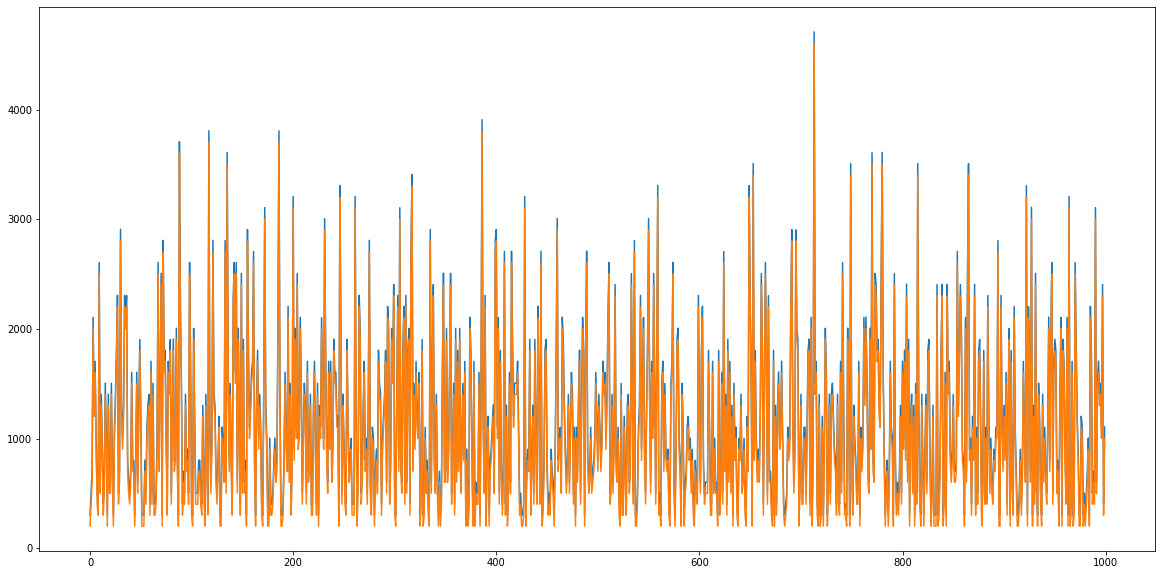

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
plt.plot(greedyR)
plt.plot(convR)

Text(0.5, 0, 'Moving Window Number')

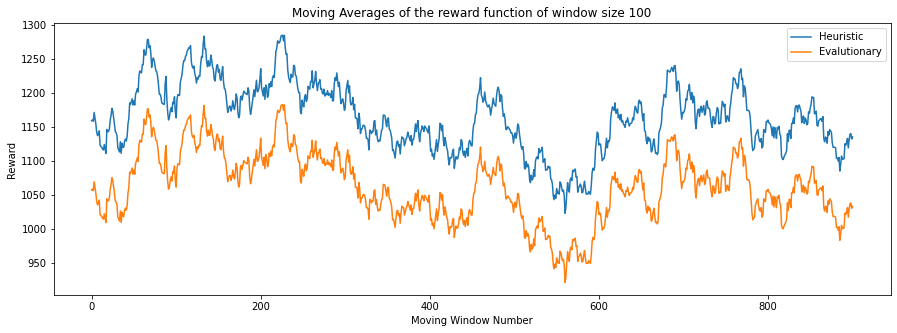

In [ ]:
heu = np.convolve(greedyR,np.ones(100,dtype=int),'valid')/100
conv = np.convolve(convR,np.ones(100,dtype=int),'valid')/100


fig = plt.figure(figsize=(15,5))
plt.plot(heu)
plt.plot(conv)
plt.title('Moving Averages of the reward function of window size 100')
plt.legend(['Heuristic', 'Evalutionary'])
plt.ylabel('Reward')
plt.xlabel('Moving Window Number')

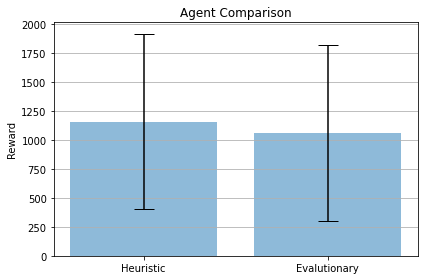

In [ ]:
means = [np.mean(greedyR), np.mean(convR)]
stds =  [np.std(greedyR), np.std(convR)]
agents = ['Heuristic', 'Evalutionary']
x_pos = np.arange(len(agents))



# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Reward')
ax.set_xticks(x_pos)
ax.set_xticklabels(agents)
ax.set_title('Agent Comparison')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('mean-std')
plt.show()

For more info on the information provided in the jsons, see [this](https://github.com/Kaggle/kaggle-environments/blob/master/kaggle_environments/envs/hungry_geese/hungry_geese.json) json;

Let's put that into a single python file and submit to Kaggle;

First we'll get the name of the notebook into a python variable:

In [ ]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

In [ ]:
py_name = nb_name[:-6] + ".py"  # swap out .ipynb for .py
print(py_name)

In [ ]:
%%writefile $py_name

from kaggle_environments.envs.hungry_geese.hungry_geese import Observation, Configuration, Action, row_col
from kaggle_environments import evaluate, make, utils
import numpy as np
actions = np.array(["EAST", "SOUTH", "NORTH", "WEST"])
opp_actions = {'EAST': 'WEST', 'WEST': 'EAST', 'NORTH':'SOUTH', 'SOUTH':'NORTH'}

# Creates a class for an agent so we can keep track of the last action
class RandomAgent:
    def __init__(self, configuration: Configuration):
        self.configuration = configuration
        self.last_action = None

    def __call__(self, observation: Observation):
        action = np.random.choice(actions) 
        while action == opp_actions.get(self.last_action, ""):
            action = np.random.choice(actions)
        self.last_action = action
        return action

cached_agents = {}
def agent(obs, config):
    index = obs["index"]
    if index not in cached_agents :
        cached_agents[index] = RandomAgent(Configuration(config))
    return cached_agents[index](Observation(obs))

In [ ]:
# Test the agent file
env.run(["1.0-bgc-Tutorial.py", "1.0-bgc-Tutorial.py"])
env.render(mode="ipython", width=500, height=450)

That's it, just submit the py file on Kaggle! Your agent will start with 600 as it's ranking and slowly gain/lose depending on how it does.

![image.png](1.0-bgc-Tutorial.png)